# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = G10_FX + ASIA_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2021-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

# Other Data

In [4]:
fwd = ['EUR1M CMPN Curncy', 'GBP1M CMPN Curncy', 'AUD1M CMPN Curncy', 
       'NZD1M CMPN Curncy', 'JPY1M CMPN Curncy', 'CAD1M CMPN Curncy', 
       'SEK1M CMPN Curncy', 'NOK1M CMPN Curncy', 'CHF1M CMPN Curncy',
       'CNH1M CMPN Curncy', 'SGD1M CMPN Curncy', 'THB1M CMPN Curncy', 
       'IHN1M CMPN Curncy', 'IRN1M CMPN Curncy', 'MRN1M CMPN Curncy', 
       'NTN1M CMPN Curncy', 'KWN1M CMPN Curncy', 'PPN1M CMPN Curncy']

fwd_scale_all = {"EURUSD": 10000,
                 "GBPUSD" : 10000,
                 "AUDUSD" : 10000,
                 "NZDUSD" : 10000,
                 "USDJPY" : 100,
                 "USDCAD" : 10000,
                 "USDSEK" : 10000,
                 "USDNOK" : 10000,
                 "USDCHF" : 10000,
                 'USDCNH': 10000,
                'USDSGD': 10000,
                'USDTHB': 100,
                'USDIDR': 1,
                'USDINR': 100,
                'USDMYR': 10000,
                'USDTWD': 1,
                'USDKRW': 1,
                'USDPHP': 1}

fwd_data = new_raw_data[fwd].pipe(fill_date)
fwd_data.columns = fwd_scale_all.keys()
for c in fwd_scale_all.keys():
  fwd_data[c] = fwd_data[c]/fwd_scale_all[c]
  
fwd_price_ori = spot_price_ori[fwd_scale_all.keys()] + fwd_data

In [5]:
rx = fwd_price_ori.pipe(standardize_series, "prices").pipe(np.log10).shift(1) - \
    spot_price_ori[fwd_scale_all.keys()].pipe(standardize_series, "prices").pipe(np.log10)

# Data integrity

In [6]:
rx.pipe(fill_date).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5635 entries, 2000-01-03 to 2021-08-06
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USDEUR  5634 non-null   float64
 1   USDGBP  5634 non-null   float64
 2   USDAUD  5634 non-null   float64
 3   USDNZD  5624 non-null   float64
 4   USDJPY  5634 non-null   float64
 5   USDCAD  5628 non-null   float64
 6   USDSEK  5631 non-null   float64
 7   USDNOK  5628 non-null   float64
 8   USDCHF  5630 non-null   float64
 9   USDCNH  2841 non-null   float64
 10  USDSGD  5624 non-null   float64
 11  USDTHB  5612 non-null   float64
 12  USDIDR  3677 non-null   float64
 13  USDINR  4005 non-null   float64
 14  USDMYR  4056 non-null   float64
 15  USDTWD  5596 non-null   float64
 16  USDKRW  4064 non-null   float64
 17  USDPHP  4030 non-null   float64
dtypes: float64(18)
memory usage: 836.4 KB


<AxesSubplot:>

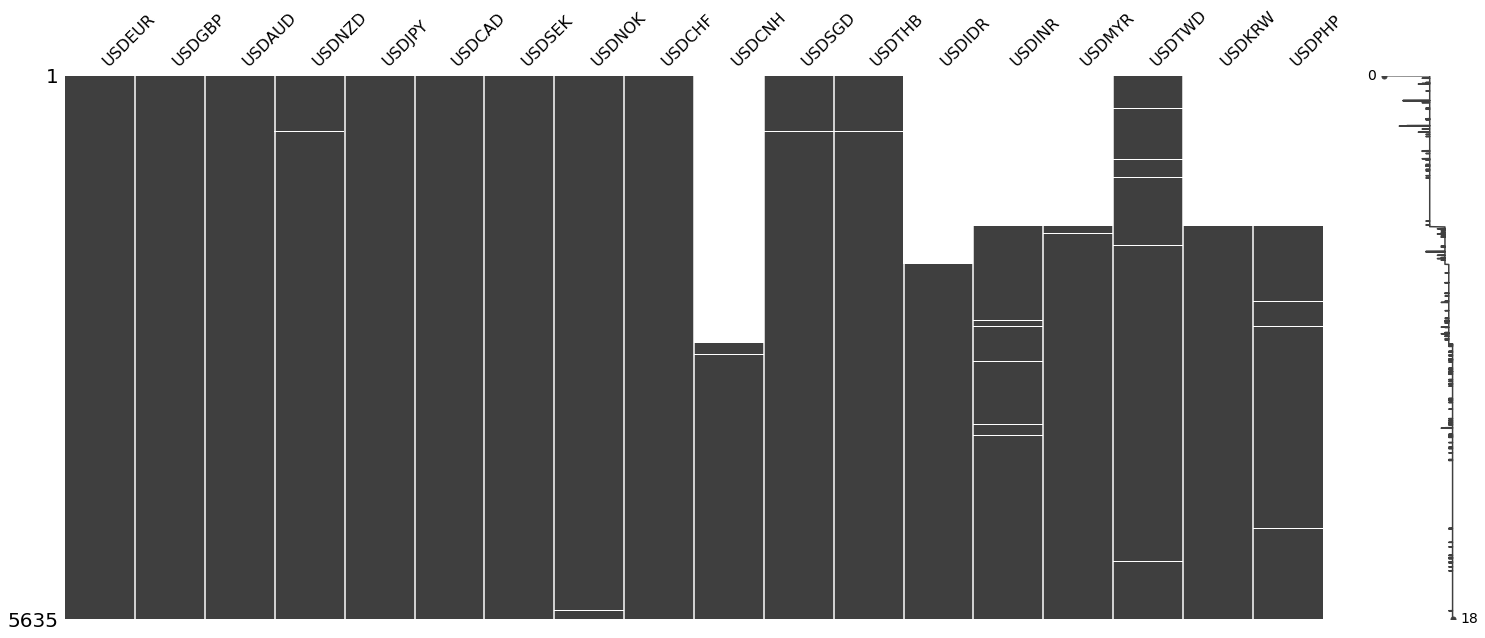

In [7]:
msmx(rx.pipe(fill_date))

# Signal

In [8]:
rx = rx.pipe(fill_date, True)

In [9]:
def rsv(x):
  mean = x.mean()
  rvu = sum([x**2 for x in x if x > mean])
  rvd = sum([x**2 for x in x if x <= mean])
  return rvd - rvu

In [10]:
rsv_signal = rx.groupby(rx.index.strftime('%Y-%m')).agg([rsv])
rsv_signal.columns = [x[0] for x in rsv_signal.columns]
rsv_signal.index = rx.loc[rx.groupby(rx.index.to_period('M')).apply(lambda x: x.index.max())].index

In [11]:
sig = rsv_signal.pipe(high_minus_low).pipe(fill_date, True)

# Backtest Daily Rebal

In [12]:
daily_bt = Backtest(signal = sig, 
                    asset_returns = total_returns, 
                    tcost = abs(total_returns*0), 
                    settings = settings,
                    settings_inject={})
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [13]:
get_summary(daily_bt)

Returns   : 0.05890890255181436
Vol       : 0.10313307968512947
SR        : 0.5711930908265925
Max DD    : -21.89

C Returns : 0.05503867013317659
C SR      : 0.48337481542586686
C Max DD  : -20.38

Hit rate  : 0.536
W | N | L : 0.54 | 0.0 | 0.46
W/L Ratio : 1.15


In [14]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF,USDSGD,USDTHB,USDTWD,USDKRW,USDPHP,USDINR,USDIDR,USDMYR,USDCNH
annualized_return,1.197852,0.020329,0.958528,-0.027262,1.242342,0.844175,0.425746,-0.174557,-0.063504,-0.659913,0.763688,-0.299501,-0.57122,0.791349,0.731639,0.86455,-0.557953,0.966283
sharpe,0.424213,0.013256,0.440101,-0.012377,0.425524,0.278957,0.155572,-0.065874,-0.019359,-0.419741,0.443697,-0.122021,-0.318925,0.300165,0.257717,0.256334,-0.3108,0.469853
dollar_sharpe,0.400219,0.007023,0.428044,-0.018617,0.433123,0.248743,0.135519,-0.077247,-0.035237,-0.437055,0.415761,-0.137064,-0.330446,0.289029,0.241342,0.234104,-0.292897,0.472685
trade_sharpe,0.572388,0.030612,0.874833,-0.110705,0.47131,0.300238,0.234577,-0.00745,0.002373,-0.850034,1.042467,-0.048805,-0.58214,0.429113,0.325544,0.265762,-0.715947,0.820241
long_sharpe,-0.314077,-0.24173,0.865806,0.215357,0.5208,0.252788,-0.036088,-0.12407,0.00721,-0.769285,0.355276,-0.052419,-0.476372,0.150683,-0.71642,1.559917,-0.607707,-0.135201
short_sharpe,0.701172,0.440346,0.944999,-0.541269,-0.542835,0.308264,0.886889,0.120465,-0.113397,-3.768612,1.291583,0.317278,-0.957412,0.533443,0.363816,0.253793,-0.773614,1.041134
sortino,0.243699,0.004682,0.20498,-0.006226,0.257801,0.176126,0.093886,-0.038645,-0.007902,-0.151486,0.149207,-0.055538,-0.111033,0.145644,0.137538,0.131306,-0.109996,0.221365
max_drawdown,-7.058419,-7.504505,-10.996142,-7.027048,-12.025908,-10.137051,-14.545662,-25.710717,-8.353675,-16.121118,-5.350799,-10.75313,-13.666716,-7.64733,-9.768841,-8.042568,-12.986285,-3.16951
max_drawdown_start,2015-05-13,2004-11-25,2010-06-07,2016-10-11,2007-06-22,2005-03-18,2005-11-16,2003-05-29,2015-01-13,2001-07-13,2009-12-31,2001-07-04,2001-12-27,2021-05-31,2011-09-02,2020-02-12,2011-10-28,2001-06-15
max_drawdown_end,2020-02-05,2016-09-06,2014-05-06,2018-03-26,2011-03-17,2006-06-28,2007-11-26,2014-11-18,2018-02-15,2012-09-14,2013-09-05,2005-05-05,2015-11-17,2021-07-20,2013-09-03,2020-03-23,2021-03-30,2014-03-06


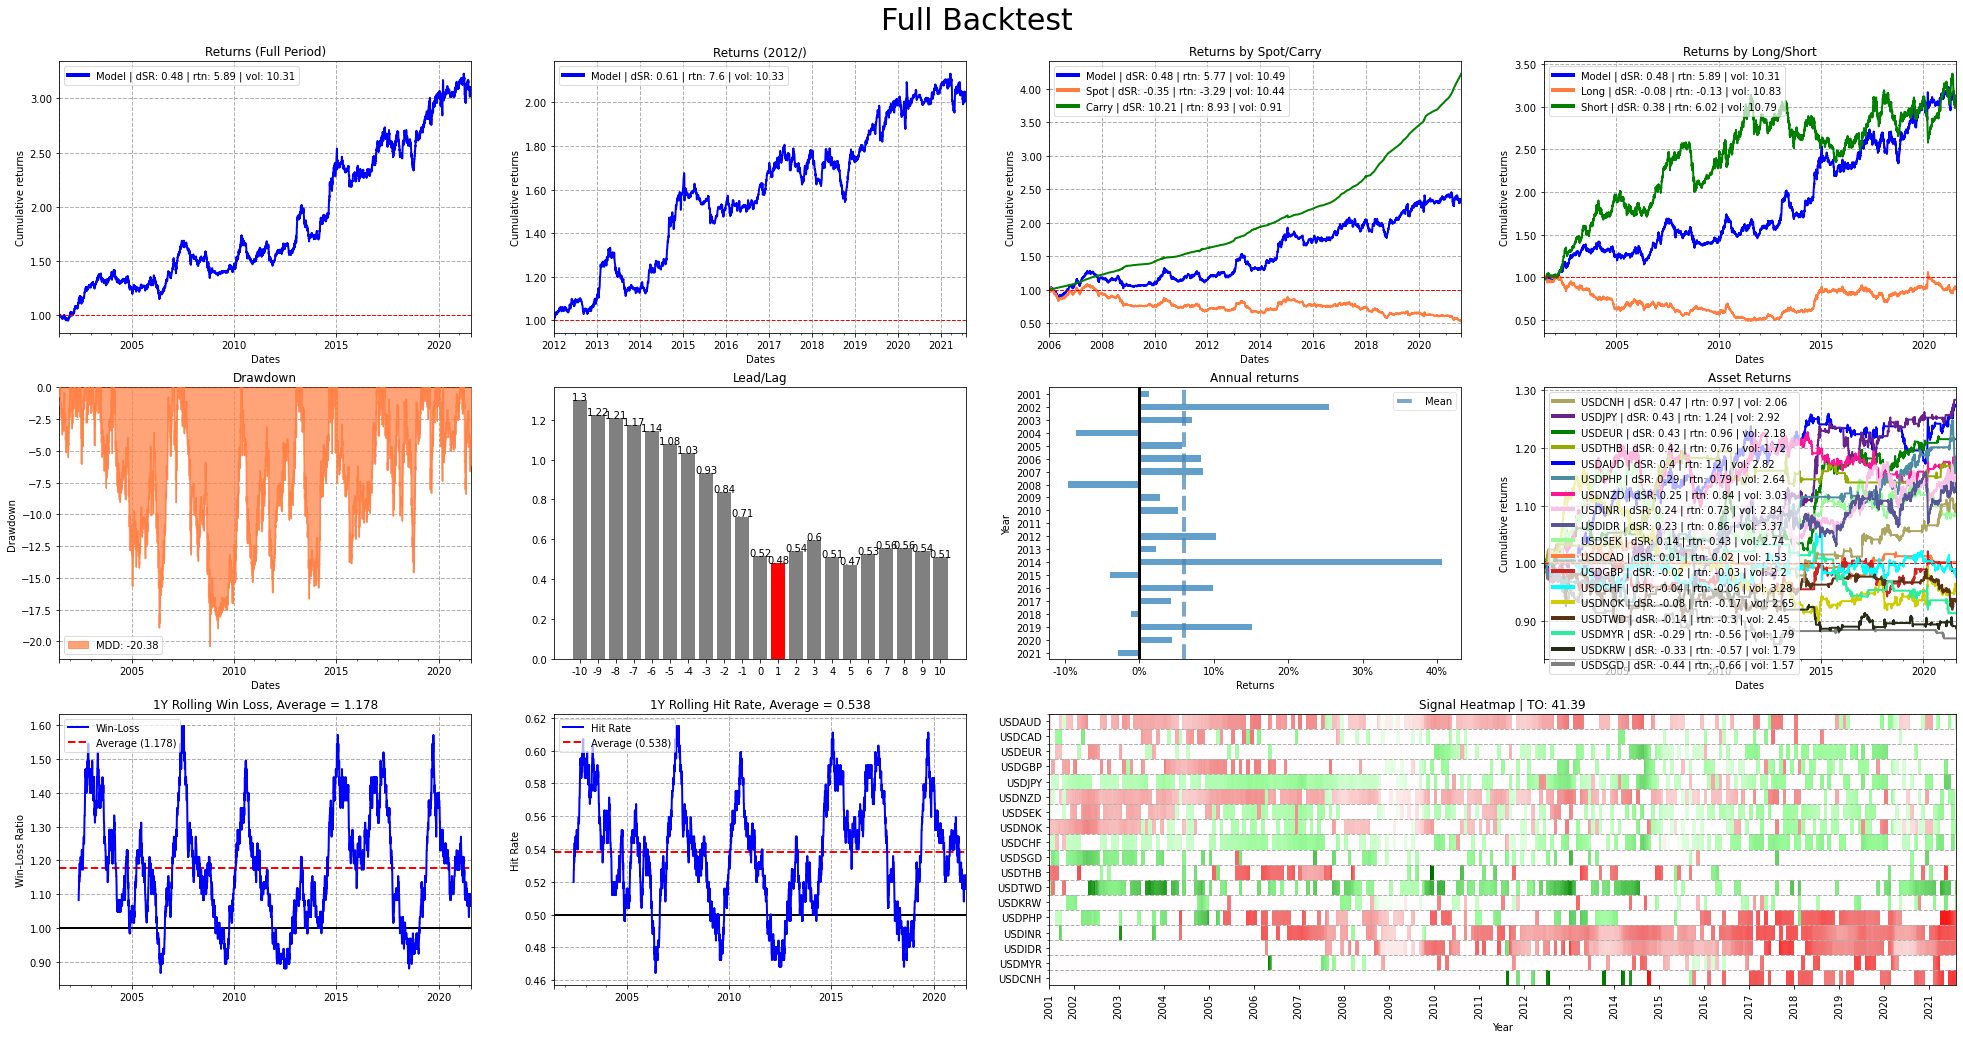

In [15]:
plot_bt(daily_bt)

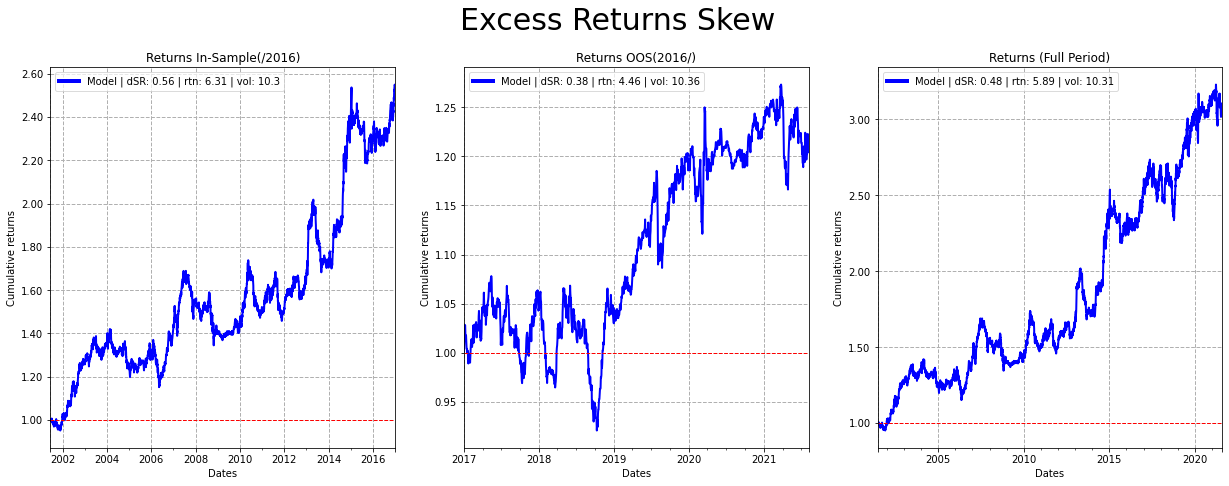

In [16]:
gs = GridSpec(nrows = 1, ncols = 3)
fig = plt.figure(figsize=(21, 7))
fig.suptitle(t="Excess Returns Skew", fontsize=30, y=1)

fig.add_subplot(gs[0]).set_label(gen_plot_rtn(daily_bt.model_rtn[:"2016"], main = "Returns In-Sample(/2016)", compound=True))
fig.add_subplot(gs[1]).set_label(gen_plot_rtn(daily_bt.model_rtn["2017":], main = "Returns OOS(2016/)", compound=True))
fig.add_subplot(gs[2]).set_label(gen_plot_rtn(daily_bt.model_rtn, main = "Returns (Full Period)", compound=True))